<h1><span style = "color: rgb(51,153,102)">Import libraries</span></h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

<h1><span style = "color: rgb(51,153,102)">Read data into a data frame</span></h1>

In [2]:
!ls -l

total 1152
-rwxrwxr-x 1 quang quang 963738 Jan 22 14:01 AmesHousing.tsv
-rwxrwxr-x 1 quang quang 208915 Jan 28 21:52 Predicting_House_Sale_Prices.ipynb


In [3]:
housing = pd.read_csv('AmesHousing.tsv', sep='\t')
housing.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

<h1><span style = "color: rgb(51,153,102)"> Create <span style="background-color: rgba(51,153,102, 0.24)">transform_features()</span></span></h1>

This function performs:
- Drop <span style="background-color: rgba(153,0,255, 0.2)">Mo Sold</span>, <span style="background-color: rgba(153,0,255, 0.2)">Yr Sold</span>, <span style="background-color: rgba(153,0,255, 0.2)">Sale Type</span>, and <span style="background-color: rgba(153,0,255, 0.2)">Sale Condition</span> columns since that leaks information about <span style="background-color: rgba(153,0,255, 0.2)">SalePrice</span>.
- Drop columns <span style="background-color: rgba(153,0,255, 0.2)">Order</span> and <span style="background-color: rgba(153,0,255, 0.2)">PID</span> that aren't useful for machine learning.
- Drop columns that has more than 5% missing values.
- Remove any houses with more than 4000 square feet from the data set, which are outliers.
- For numerical columns that has less than 5% missing values, let's fill in the missing values using the most popular value for that column.
- Create feature <span style="background-color: rgba(153,0,255, 0.2)">years_until_remod</span> and drop columns <span style="background-color: rgba(153,0,255, 0.2)">Year Remod/Add</span>, <span style="background-color: rgba(153,0,255, 0.2)">Year Built</span>.

In [5]:
def transform_features(data):
    new_df = data.drop(['Mo Sold', 'Yr Sold', 'Order', 'PID', 'Sale Condition', 'Sale Type'], axis=1)
    
    null_counts = new_df.isnull().sum()    
    new_df = new_df[null_counts[((null_counts / data.shape[0]) < 0.05)].index]
    
    new_df = new_df[new_df['Gr Liv Area'] < 4000]
    
    num_cols = new_df.select_dtypes(['int64', 'float64']).columns
    
    for col in num_cols:
        if new_df[col].isnull().sum() > 0:
            fill_value = new_df[col].value_counts().index[0]
            new_df = new_df.fillna(fill_value)
            
    new_df['years_until_remod'] = new_df['Year Remod/Add'] - new_df['Year Built']
    new_df = new_df.drop(['Year Remod/Add', 'Year Built'], axis=1)
    
    return new_df

Generate a correlation heatmap matrix of the numerical features in the training data set.

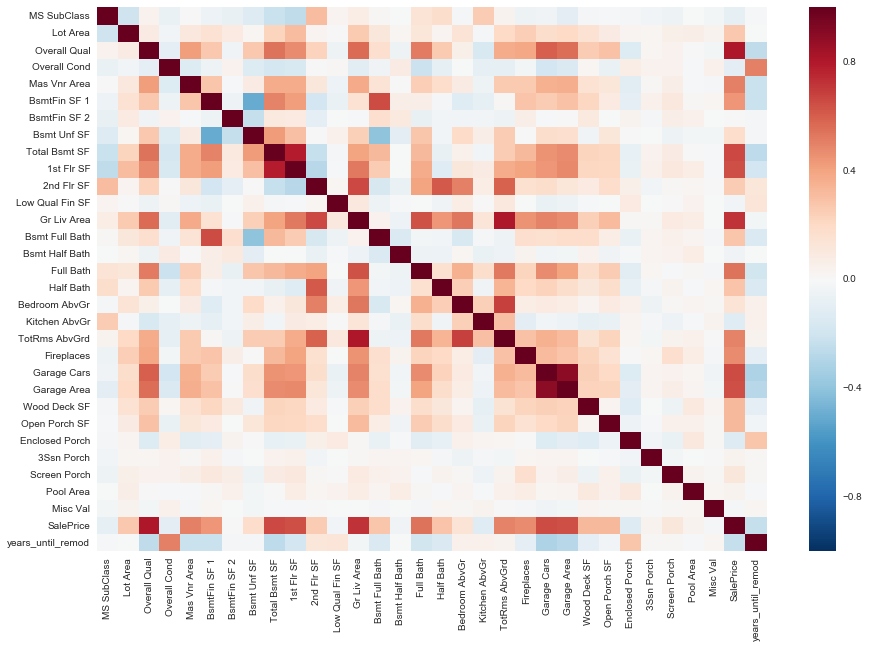

In [6]:
transformed_df = transform_features(housing)

fig = plt.subplots(figsize=(15, 10))
sns.heatmap(transformed_df.select_dtypes(['int64', 'float64']).corr())
plt.show()

Which features correlate strongly with our target column, SalePrice?

In [7]:
transformed_df.select_dtypes(['int64', 'float64']).corr()['SalePrice'].sort_values(ascending=False)

SalePrice            1.000000
Overall Qual         0.805236
Gr Liv Area          0.719463
Total Bsmt SF        0.658863
Garage Cars          0.652227
Garage Area          0.648050
1st Flr SF           0.642902
Full Bath            0.544486
Mas Vnr Area         0.506895
TotRms AbvGrd        0.498477
Fireplaces           0.474878
BsmtFin SF 1         0.444721
Wood Deck SF         0.326911
Open Porch SF        0.322075
Half Bath            0.284458
Bsmt Full Bath       0.280989
Lot Area             0.270047
2nd Flr SF           0.257132
Bsmt Unf SF          0.185632
Bedroom AbvGr        0.139766
Screen Porch         0.115556
Pool Area            0.035491
3Ssn Porch           0.033305
BsmtFin SF 2         0.007565
Misc Val            -0.019183
Low Qual Fin SF     -0.037836
Bsmt Half Bath      -0.045720
MS SubClass         -0.086906
Overall Cond        -0.103296
Kitchen AbvGr       -0.120938
Enclosed Porch      -0.129339
years_until_remod   -0.241975
Name: SalePrice, dtype: float64

<h1><span style = "color: rgb(51,153,102)"> Create <span style="background-color: rgba(51,153,102, 0.24)">select_features()</span></span></h1>
- Drop numerical columns that its correlation coefficient with SalePrice are less than a threshold.
- Transform text columns to categorical. 
- Drop category columns that has more than 10 unique values or 95% of the values in the column belong to a specific category.
- Convert all category columns to dummy columns

In [8]:
nominal_cols = ['MS SubClass', 'MS Zoning', 'Street' ,'Alley', 'Land Contour' ,'Lot Config' ,'Neighborhood' ,'Condition 1',
               'Condition 2', 'Bldg Type' ,'House Style' ,'Roof Style', 'Roof Matl', 'Exterior 1st' ,'Exterior 2nd',
                'Mas Vnr Type', 'Foundation', 'Heating', 'Central Air', 'Misc Feature', 'Garage Type', 'Sale Type', 'Sale Condition']

In [9]:
def select_features(df, coeff_threshold=0.5, cat_th=0.95, uniq_count=5):
    corr_target = df.select_dtypes(['int64', 'float64']).corr()['SalePrice']
    drop_cols = corr_target[corr_target < coeff_threshold].index
    new_df = df.drop(drop_cols, axis=1)
    
    for col in new_df.select_dtypes(['object']):
        if col in nominal_cols:
            if (new_df[col].value_counts().head(1).item() / new_df[col].shape[0] > cat_th) | (len(new_df[col].value_counts()) > uniq_count):
                df = df.drop(col, axis=1)
                
    for col in new_df.select_dtypes(['object']).columns:
        new_df[col] = new_df[col].astype('category')
        
    dummy_cols = pd.get_dummies(new_df.select_dtypes(['category']))
    new_df = new_df.drop(new_df.select_dtypes(['category']).columns, axis=1)
    new_df = pd.concat([new_df, dummy_cols], axis=1)
    
    
    return df

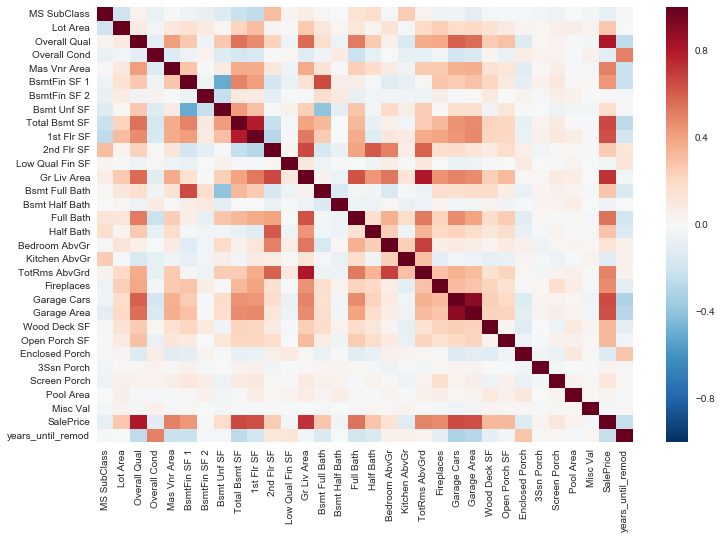

In [10]:
selected_df = select_features(transformed_df)

fig = plt.subplots(figsize = (12, 8))
sns.heatmap(selected_df.select_dtypes(['int64', 'float64']).corr())
plt.show()

<h1><span style = "color: rgb(51,153,102)"> Create <span style="background-color: rgba(51,153,102, 0.24)">train_and_test()</span></span></h1>

The <span style="background-color: rgba(153,0,255, 0.2)">train_and_test()</span> function performs:
- Selects the first <span style="background-color: rgba(153,0,255, 0.2)">1460</span> rows from from data and assign to <span style="background-color: rgba(153,0,255, 0.2)">train</span>.
- Selects the remaining rows from data and assign to <span style="background-color: rgba(153,0,255, 0.2)">test</span>.
- Trains a model using all numerical columns except the <span style="background-color: rgba(153,0,255, 0.2)">SalePrice</span> column (the target column) from the data frame returned from <span style="background-color: rgba(153,0,255, 0.2)">select_features()</span>.
- Tests the model on the test set using and returns the RMSE value.

In [11]:
def train_and_test(data, k=0):
    numeric_df = data.select_dtypes(include=['integer', 'float'])
    target = 'SalePrice'
    features = numeric_df.columns.drop(target)
    lr = LinearRegression()
    
    if k==0:
        train = data[:1460]
        test = data[1460:]

        lr.fit(train[features], train[target])
        prediction = lr.predict(test[features])
        rmse = np.sqrt(mean_squared_error(prediction, test[target]))
        
        return rmse
        
    if k==1:
        shuffled_data = data.sample(frac=1)
        fold_one = shuffled_data[:1460]
        fold_two = shuffled_data[1460:]

        lr.fit(fold_one[features], fold_one[target])
        prediction_one = lr.predict(fold_two[features])
        rmse_one = np.sqrt(mean_squared_error(prediction_one, fold_two[target]))
        
        lr.fit(fold_two[features], fold_two[target])
        prediction_two = lr.predict(fold_one[features])
        rmse_two = np.sqrt(mean_squared_error(prediction_two, fold_one[target]))
        
        return (rmse_one + rmse_two) / 2
    else:
        scores = cross_val_score(lr, data[features], data[target], cv=KFold(n_splits=k, shuffle=True),
                               scoring='neg_mean_squared_error')
        rmse_values = np.sqrt(-scores)
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse

In [12]:
df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
housing_tf = transform_features(df)
housing_sf = select_features(housing_tf)
rmse = train_and_test(housing_sf, k=4)
rmse

[ 29605.78903358  26501.60075698  30478.09016014  29801.34743849]


29096.706847296235